In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")


df_orders = pd.read_csv('orders_aggregated.csv')
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

print(f"Dataset carregado: {len(df_orders):,} pedidos")
print()


Dataset carregado: 98,658 pedidos



Testes de normalidade

In [12]:
print("\nVerificando se as variáveis seguem distribuição normal...")
print()

def test_normality(data, var_name):
    clean_data = data.dropna()
    
    if len(clean_data) > 5000:
        sample = clean_data.sample(5000, random_state=42)
    else:
        sample = clean_data
    
    print(f"\n{var_name.upper()}")
    print(f"  N = {len(clean_data):,}")
    
    # Teste de Shapiro-Wilk 
    if len(sample) <= 5000:
        stat_sw, p_sw = shapiro(sample)
        print(f"  Shapiro-Wilk: estatística={stat_sw:.4f}, p-valor={p_sw:.4e}")
        print(f"    → {'Normal' if p_sw > 0.05 else 'Não-Normal'} (α=0.05)")
    
    # Teste de D'Agostino-Pearson
    stat_dp, p_dp = normaltest(sample)
    print(f"  D'Agostino-Pearson: estatística={stat_dp:.4f}, p-valor={p_dp:.4e}")
    print(f"    → {'Normal' if p_dp > 0.05 else 'Não-Normal'} (α=0.05)")
    
    # Assimetria e Curtose
    skewness = stats.skew(clean_data)
    kurtosis = stats.kurtosis(clean_data)
    print(f"  Assimetria: {skewness:.4f}")
    print(f"  Curtose: {kurtosis:.4f}")
    
    return p_dp > 0.05

vars_to_test = {
    'total': df_orders['total'],
    'freight': df_orders['freight'],
    'delivery_lead_time': df_orders['delivery_lead_time']
}

normality_results = {}
for var_name, data in vars_to_test.items():
    normality_results[var_name] = test_normality(data, var_name)

print()
print("CONCLUSÃO DOS TESTES DE NORMALIDADE:")
for var, is_normal in normality_results.items():
    print(f"  {var}: {'Normal' if is_normal else 'Não-Normal'}")
print("\n⚠ A maioria das variáveis não segue distribuição normal.")
print("  Usaremos Teorema Central do Limite (n > 30) para ICs das médias.")
print()


Verificando se as variáveis seguem distribuição normal...


TOTAL
  N = 98,658
  Shapiro-Wilk: estatística=0.4963, p-valor=2.6163e-80
    → Não-Normal (α=0.05)
  D'Agostino-Pearson: estatística=6507.6359, p-valor=0.0000e+00
    → Não-Normal (α=0.05)
  Assimetria: 9.2295
  Curtose: 239.7646

FREIGHT
  N = 98,658
  Shapiro-Wilk: estatística=0.4153, p-valor=1.4415e-83
    → Não-Normal (α=0.05)
  D'Agostino-Pearson: estatística=9670.5991, p-valor=0.0000e+00
    → Não-Normal (α=0.05)
  Assimetria: 12.0522
  Curtose: 565.2802

DELIVERY_LEAD_TIME
  N = 96,476
  Shapiro-Wilk: estatística=0.7741, p-valor=6.4934e-64
    → Não-Normal (α=0.05)
  D'Agostino-Pearson: estatística=4185.9616, p-valor=0.0000e+00
    → Não-Normal (α=0.05)
  Assimetria: 3.8287
  Curtose: 39.2599

CONCLUSÃO DOS TESTES DE NORMALIDADE:
  total: Não-Normal
  freight: Não-Normal
  delivery_lead_time: Não-Normal

⚠ A maioria das variáveis não segue distribuição normal.
  Usaremos Teorema Central do Limite (n > 30) para ICs das

INTERVALOS DE CONFIANÇA PARA MÉDIAS

In [4]:
print("2. INTERVALOS DE CONFIANÇA (95%) PARA MÉDIAS")
print()

def calculate_ci_mean(data, confidence=0.95):
    clean_data = data.dropna()
    n = len(clean_data)
    mean = clean_data.mean()
    std_error = stats.sem(clean_data)
    
    # Usar distribuição t de Student
    ci = stats.t.interval(confidence, n-1, loc=mean, scale=std_error)
    
    margin = ci[1] - mean
    
    return {
        'n': n,
        'mean': mean,
        'std': clean_data.std(),
        'se': std_error,
        'ci_lower': ci[0],
        'ci_upper': ci[1],
        'margin': margin
    }

print("2.1. TICKET MÉDIO (Total por pedido)")
ci_ticket = calculate_ci_mean(df_orders['total'])
print(f"  N = {ci_ticket['n']:,}")
print(f"  Média = R$ {ci_ticket['mean']:.2f}")
print(f"  Desvio Padrão = R$ {ci_ticket['std']:.2f}")
print(f"  Erro Padrão = R$ {ci_ticket['se']:.2f}")
print(f"  IC 95% = [R$ {ci_ticket['ci_lower']:.2f}, R$ {ci_ticket['ci_upper']:.2f}]")
print(f"  Margem de Erro = ± R$ {ci_ticket['margin']:.2f}")
print()

print("2.2. VALOR DO FRETE")
ci_freight = calculate_ci_mean(df_orders['freight'])
print(f"  N = {ci_freight['n']:,}")
print(f"  Média = R$ {ci_freight['mean']:.2f}")
print(f"  Desvio Padrão = R$ {ci_freight['std']:.2f}")
print(f"  Erro Padrão = R$ {ci_freight['se']:.2f}")
print(f"  IC 95% = [R$ {ci_freight['ci_lower']:.2f}, R$ {ci_freight['ci_upper']:.2f}]")
print(f"  Margem de Erro = ± R$ {ci_freight['margin']:.2f}")
print()

print("2.3. PRAZO DE ENTREGA (dias)")
ci_delivery = calculate_ci_mean(df_orders['delivery_lead_time'])
print(f"  N = {ci_delivery['n']:,}")
print(f"  Média = {ci_delivery['mean']:.2f} dias")
print(f"  Desvio Padrão = {ci_delivery['std']:.2f} dias")
print(f"  Erro Padrão = {ci_delivery['se']:.2f} dias")
print(f"  IC 95% = [{ci_delivery['ci_lower']:.2f}, {ci_delivery['ci_upper']:.2f}] dias")
print(f"  Margem de Erro = ± {ci_delivery['margin']:.2f} dias")
print()

print("2.4. ATRASO NA ENTREGA (dias, quando atrasado)")
delivered = df_orders[df_orders['order_status'] == 'delivered']
late_orders = delivered[delivered['is_late'] == 1]
ci_delay = calculate_ci_mean(late_orders['delivery_delay_days'])
print(f"  N = {ci_delay['n']:,}")
print(f"  Média = {ci_delay['mean']:.2f} dias")
print(f"  Desvio Padrão = {ci_delay['std']:.2f} dias")
print(f"  Erro Padrão = {ci_delay['se']:.2f} dias")
print(f"  IC 95% = [{ci_delay['ci_lower']:.2f}, {ci_delay['ci_upper']:.2f}] dias")
print(f"  Margem de Erro = ± {ci_delay['margin']:.2f} dias")
print()

2. INTERVALOS DE CONFIANÇA (95%) PARA MÉDIAS

2.1. TICKET MÉDIO (Total por pedido)
  N = 98,658
  Média = R$ 160.57
  Desvio Padrão = R$ 220.45
  Erro Padrão = R$ 0.70
  IC 95% = [R$ 159.19, R$ 161.94]
  Margem de Erro = ± R$ 1.38

2.2. VALOR DO FRETE
  N = 98,658
  Média = R$ 22.82
  Desvio Padrão = R$ 21.65
  Erro Padrão = R$ 0.07
  IC 95% = [R$ 22.69, R$ 22.96]
  Margem de Erro = ± R$ 0.14

2.3. PRAZO DE ENTREGA (dias)
  N = 96,476
  Média = 12.09 dias
  Desvio Padrão = 9.55 dias
  Erro Padrão = 0.03 dias
  IC 95% = [12.03, 12.15] dias
  Margem de Erro = ± 0.06 dias

2.4. ATRASO NA ENTREGA (dias, quando atrasado)
  N = 6,534
  Média = 10.62 dias
  Desvio Padrão = 14.64 dias
  Erro Padrão = 0.18 dias
  IC 95% = [10.26, 10.98] dias
  Margem de Erro = ± 0.36 dias



INTERVALOS DE CONFIANÇA PARA PROPORÇÕES

In [6]:
def calculate_ci_proportion(successes, n, confidence=0.95):
    """Calcula intervalo de confiança para proporção"""
    p = successes / n
    z = stats.norm.ppf((1 + confidence) / 2)
    
    # Método de Wilson (mais preciso)
    denominator = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p * (1-p) / n + z**2 / (4*n**2))) / denominator
    
    ci_lower = center - margin
    ci_upper = center + margin
    
    return {
        'n': n,
        'successes': successes,
        'proportion': p,
        'ci_lower': max(0, ci_lower),
        'ci_upper': min(1, ci_upper),
        'margin': margin
    }

print("3.1. TAXA DE ATRASO NA ENTREGA")
n_delivered = len(delivered)
n_late = delivered['is_late'].sum()
ci_late_rate = calculate_ci_proportion(n_late, n_delivered)
print(f"  N (entregues) = {ci_late_rate['n']:,}")
print(f"  Atrasados = {ci_late_rate['successes']:,}")
print(f"  Proporção = {ci_late_rate['proportion']:.4f} ({ci_late_rate['proportion']*100:.2f}%)")
print(f"  IC 95% = [{ci_late_rate['ci_lower']:.4f}, {ci_late_rate['ci_upper']:.4f}]")
print(f"           = [{ci_late_rate['ci_lower']*100:.2f}%, {ci_late_rate['ci_upper']*100:.2f}%]")
print(f"  Margem de Erro = ± {ci_late_rate['margin']*100:.2f}%")
print()

print("3.2. TAXA DE CONFIRMAÇÃO (Delivered)")
n_total = len(df_orders)
n_confirmed = df_orders['is_confirmed'].sum()
ci_confirm_rate = calculate_ci_proportion(n_confirmed, n_total)
print(f"  N (total) = {ci_confirm_rate['n']:,}")
print(f"  Confirmados = {ci_confirm_rate['successes']:,}")
print(f"  Proporção = {ci_confirm_rate['proportion']:.4f} ({ci_confirm_rate['proportion']*100:.2f}%)")
print(f"  IC 95% = [{ci_confirm_rate['ci_lower']:.4f}, {ci_confirm_rate['ci_upper']:.4f}]")
print(f"           = [{ci_confirm_rate['ci_lower']*100:.2f}%, {ci_confirm_rate['ci_upper']*100:.2f}%]")
print(f"  Margem de Erro = ± {ci_confirm_rate['margin']*100:.2f}%")
print()

print("3.3. TAXA DE CANCELAMENTO")
n_canceled = df_orders['is_canceled'].sum()
ci_cancel_rate = calculate_ci_proportion(n_canceled, n_total)
print(f"  N (total) = {ci_cancel_rate['n']:,}")
print(f"  Cancelados = {ci_cancel_rate['successes']:,}")
print(f"  Proporção = {ci_cancel_rate['proportion']:.4f} ({ci_cancel_rate['proportion']*100:.2f}%)")
print(f"  IC 95% = [{ci_cancel_rate['ci_lower']:.4f}, {ci_cancel_rate['ci_upper']:.4f}]")
print(f"           = [{ci_cancel_rate['ci_lower']*100:.2f}%, {ci_cancel_rate['ci_upper']*100:.2f}%]")
print(f"  Margem de Erro = ± {ci_cancel_rate['margin']*100:.2f}%")
print()

3.1. TAXA DE ATRASO NA ENTREGA
  N (entregues) = 96,478
  Atrasados = 6,534
  Proporção = 0.0677 (6.77%)
  IC 95% = [0.0662, 0.0693]
           = [6.62%, 6.93%]
  Margem de Erro = ± 0.16%

3.2. TAXA DE CONFIRMAÇÃO (Delivered)
  N (total) = 98,658
  Confirmados = 96,478
  Proporção = 0.9779 (97.79%)
  IC 95% = [0.9770, 0.9788]
           = [97.70%, 97.88%]
  Margem de Erro = ± 0.09%

3.3. TAXA DE CANCELAMENTO
  N (total) = 98,658
  Cancelados = 461
  Proporção = 0.0047 (0.47%)
  IC 95% = [0.0043, 0.0051]
           = [0.43%, 0.51%]
  Margem de Erro = ± 0.04%



COMPARAÇÃO ENTRE GRUPOS - TESTE T

In [7]:
print("4.1. TICKET MÉDIO: Cartão de Crédito vs Boleto")
credit_card = df_orders[df_orders['payment_type'] == 'credit_card']['total'].dropna()
boleto = df_orders[df_orders['payment_type'] == 'boleto']['total'].dropna()

print(f"  Cartão de Crédito: N={len(credit_card):,}, Média=R$ {credit_card.mean():.2f}")
print(f"  Boleto: N={len(boleto):,}, Média=R$ {boleto.mean():.2f}")

# Teste t de Welch (não assume variâncias iguais)
t_stat, p_value = stats.ttest_ind(credit_card, boleto, equal_var=False)
print(f"  Teste t de Welch: t={t_stat:.4f}, p-valor={p_value:.4e}")
print(f"  → Diferença {'SIGNIFICATIVA' if p_value < 0.05 else 'NÃO significativa'} (α=0.05)")
print()

print("4.2. PRAZO DE ENTREGA: Sudeste vs Nordeste")
sudeste = df_orders[df_orders['customer_region'] == 'Sudeste']['delivery_lead_time'].dropna()
nordeste = df_orders[df_orders['customer_region'] == 'Nordeste']['delivery_lead_time'].dropna()

print(f"  Sudeste: N={len(sudeste):,}, Média={sudeste.mean():.2f} dias")
print(f"  Nordeste: N={len(nordeste):,}, Média={nordeste.mean():.2f} dias")

t_stat2, p_value2 = stats.ttest_ind(sudeste, nordeste, equal_var=False)
print(f"  Teste t de Welch: t={t_stat2:.4f}, p-valor={p_value2:.4e}")
print(f"  → Diferença {'SIGNIFICATIVA' if p_value2 < 0.05 else 'NÃO significativa'} (α=0.05)")
print()

4.1. TICKET MÉDIO: Cartão de Crédito vs Boleto
  Cartão de Crédito: N=75,615, Média=R$ 166.20
  Boleto: N=19,614, Média=R$ 144.91
  Teste t de Welch: t=12.3259, p-valor=7.9040e-35
  → Diferença SIGNIFICATIVA (α=0.05)

4.2. PRAZO DE ENTREGA: Sudeste vs Nordeste
  Sudeste: N=66,198, Média=10.29 dias
  Nordeste: N=9,044, Média=19.54 dias
  Teste t de Welch: t=-69.5059, p-valor=0.0000e+00
  → Diferença SIGNIFICATIVA (α=0.05)



VISUALIZAÇÃO DOS INTERVALOS DE CONFIANÇA

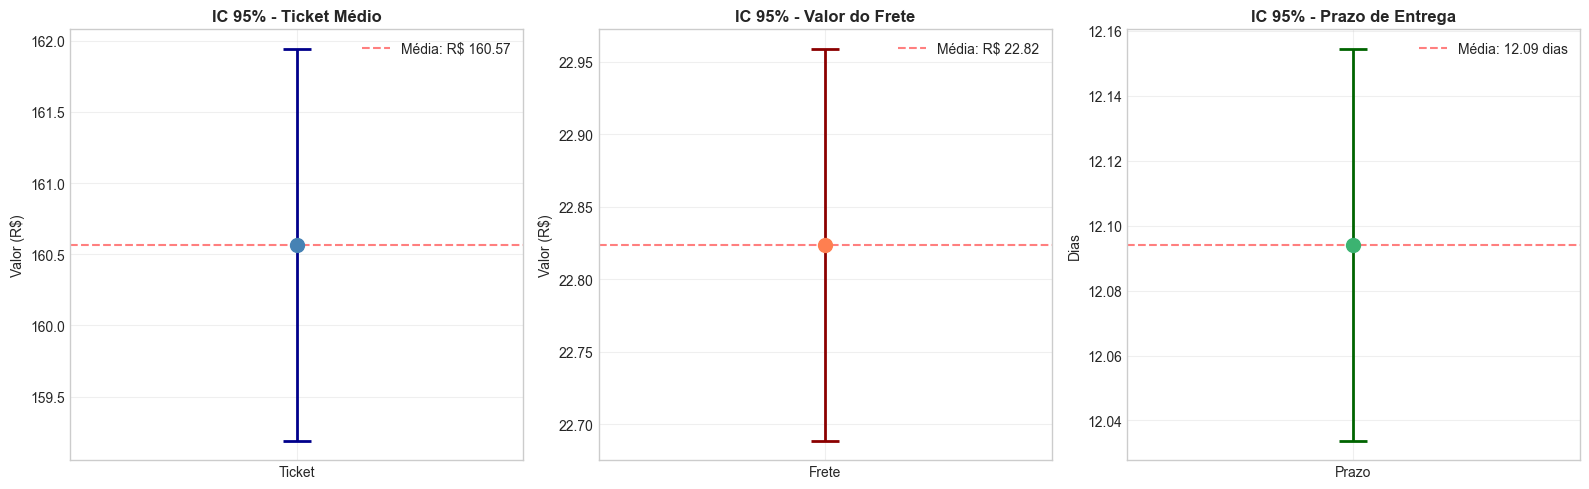

✓ Salvo: inference_01_confidence_intervals.png


In [9]:

# Gráfico de ICs para médias
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ticket Médio
axes[0].errorbar([1], [ci_ticket['mean']], 
                 yerr=[[ci_ticket['mean']-ci_ticket['ci_lower']], 
                       [ci_ticket['ci_upper']-ci_ticket['mean']]], 
                 fmt='o', markersize=10, capsize=10, capthick=2, 
                 color='steelblue', ecolor='darkblue', linewidth=2)
axes[0].axhline(ci_ticket['mean'], color='red', linestyle='--', alpha=0.5, 
                label=f'Média: R$ {ci_ticket["mean"]:.2f}')
axes[0].set_xlim(0.5, 1.5)
axes[0].set_ylabel('Valor (R$)')
axes[0].set_title('IC 95% - Ticket Médio', fontweight='bold')
axes[0].set_xticks([1])
axes[0].set_xticklabels(['Ticket'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Frete
axes[1].errorbar([1], [ci_freight['mean']], 
                 yerr=[[ci_freight['mean']-ci_freight['ci_lower']], 
                       [ci_freight['ci_upper']-ci_freight['mean']]], 
                 fmt='o', markersize=10, capsize=10, capthick=2, 
                 color='coral', ecolor='darkred', linewidth=2)
axes[1].axhline(ci_freight['mean'], color='red', linestyle='--', alpha=0.5, 
                label=f'Média: R$ {ci_freight["mean"]:.2f}')
axes[1].set_xlim(0.5, 1.5)
axes[1].set_ylabel('Valor (R$)')
axes[1].set_title('IC 95% - Valor do Frete', fontweight='bold')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['Frete'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Prazo de Entrega
axes[2].errorbar([1], [ci_delivery['mean']], 
                 yerr=[[ci_delivery['mean']-ci_delivery['ci_lower']], 
                       [ci_delivery['ci_upper']-ci_delivery['mean']]], 
                 fmt='o', markersize=10, capsize=10, capthick=2, 
                 color='mediumseagreen', ecolor='darkgreen', linewidth=2)
axes[2].axhline(ci_delivery['mean'], color='red', linestyle='--', alpha=0.5, 
                label=f'Média: {ci_delivery["mean"]:.2f} dias')
axes[2].set_xlim(0.5, 1.5)
axes[2].set_ylabel('Dias')
axes[2].set_title('IC 95% - Prazo de Entrega', fontweight='bold')
axes[2].set_xticks([1])
axes[2].set_xticklabels(['Prazo'])
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('./outputs/03_statistical_inference/inference_01_confidence_intervals.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Salvo: inference_01_confidence_intervals.png")





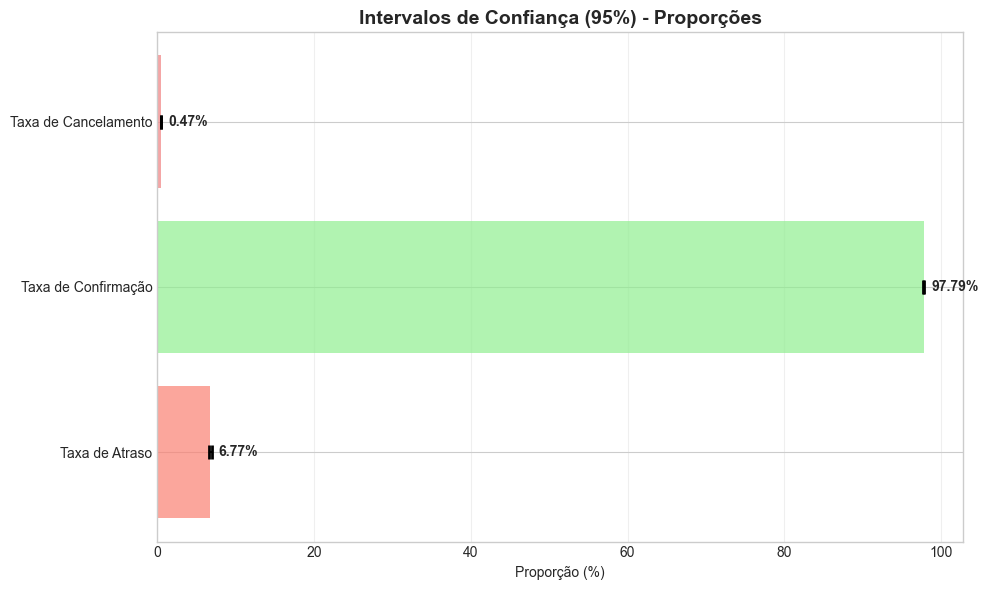

✓ Salvo: inference_02_proportion_intervals.png


In [10]:
# Gráfico de ICs para proporções
fig, ax = plt.subplots(figsize=(10, 6))

proportions = [
    ('Taxa de Atraso', ci_late_rate['proportion']*100, 
     (ci_late_rate['proportion']-ci_late_rate['ci_lower'])*100,
     (ci_late_rate['ci_upper']-ci_late_rate['proportion'])*100),
    ('Taxa de Confirmação', ci_confirm_rate['proportion']*100,
     (ci_confirm_rate['proportion']-ci_confirm_rate['ci_lower'])*100,
     (ci_confirm_rate['ci_upper']-ci_confirm_rate['proportion'])*100),
    ('Taxa de Cancelamento', ci_cancel_rate['proportion']*100,
     (ci_cancel_rate['proportion']-ci_cancel_rate['ci_lower'])*100,
     (ci_cancel_rate['ci_upper']-ci_cancel_rate['proportion'])*100)
]

labels = [p[0] for p in proportions]
values = [p[1] for p in proportions]
errors_lower = [p[2] for p in proportions]
errors_upper = [p[3] for p in proportions]

x_pos = np.arange(len(labels))
ax.barh(x_pos, values, color=['salmon', 'lightgreen', 'lightcoral'], alpha=0.7)
ax.errorbar(values, x_pos, xerr=[errors_lower, errors_upper], 
            fmt='none', ecolor='black', capsize=5, capthick=2)

ax.set_yticks(x_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Proporção (%)')
ax.set_title('Intervalos de Confiança (95%) - Proporções', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

for i, (label, value) in enumerate(zip(labels, values)):
    ax.text(value + 1, i, f'{value:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('./outputs/03_statistical_inference/inference_02_proportion_intervals.png', dpi=300, bbox_inches='tight')
plt.close()
print("✓ Salvo: inference_02_proportion_intervals.png")

SALVAR RESULTADOS

In [11]:
inference_results = pd.DataFrame({
    'Métrica': [
        'Ticket Médio (R$)',
        'Valor do Frete (R$)',
        'Prazo de Entrega (dias)',
        'Atraso na Entrega (dias)',
        'Taxa de Atraso (%)',
        'Taxa de Confirmação (%)',
        'Taxa de Cancelamento (%)'
    ],
    'N': [
        ci_ticket['n'],
        ci_freight['n'],
        ci_delivery['n'],
        ci_delay['n'],
        ci_late_rate['n'],
        ci_confirm_rate['n'],
        ci_cancel_rate['n']
    ],
    'Estimativa': [
        f"{ci_ticket['mean']:.2f}",
        f"{ci_freight['mean']:.2f}",
        f"{ci_delivery['mean']:.2f}",
        f"{ci_delay['mean']:.2f}",
        f"{ci_late_rate['proportion']*100:.2f}",
        f"{ci_confirm_rate['proportion']*100:.2f}",
        f"{ci_cancel_rate['proportion']*100:.2f}"
    ],
    'IC_95_Lower': [
        f"{ci_ticket['ci_lower']:.2f}",
        f"{ci_freight['ci_lower']:.2f}",
        f"{ci_delivery['ci_lower']:.2f}",
        f"{ci_delay['ci_lower']:.2f}",
        f"{ci_late_rate['ci_lower']*100:.2f}",
        f"{ci_confirm_rate['ci_lower']*100:.2f}",
        f"{ci_cancel_rate['ci_lower']*100:.2f}"
    ],
    'IC_95_Upper': [
        f"{ci_ticket['ci_upper']:.2f}",
        f"{ci_freight['ci_upper']:.2f}",
        f"{ci_delivery['ci_upper']:.2f}",
        f"{ci_delay['ci_upper']:.2f}",
        f"{ci_late_rate['ci_upper']*100:.2f}",
        f"{ci_confirm_rate['ci_upper']*100:.2f}",
        f"{ci_cancel_rate['ci_upper']*100:.2f}"
    ]
})

inference_results.to_csv('./outputs/03_statistical_inference/statistical_inference_results.csv', index=False)
print("✓ Arquivo salvo: statistical_inference_results.csv")


✓ Arquivo salvo: statistical_inference_results.csv
